# 1. Importing Required Libraries

In [32]:
import torch
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import tempfile
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import optuna
import os

In [2]:
# Suppress Optuna warnings for cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
current_dir = os.getcwd()
print(current_dir)

c:\Aravind's File\Projects\pytorch_multi_classification


In [4]:
# --- Configuration ---
RANDOM_SEED = 42
BATCH_SIZE = 64
NUM_TRIALS_OPTUNA = 30
LOG_DIR = os.path.join(current_dir, "runs/wine_classification")
CSV_LOG_FILE = os.path.join(current_dir, "runs/wine_classification", "training_metrics.csv")
final_CSV_LOG_FILE = os.path.join(current_dir, "runs/wine_classification", "final_refit_metrics.csv")

In [5]:
# Create the folder if it doesn't exist
os.makedirs("runs/california_housing_regression", exist_ok=True)

In [6]:
# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [7]:
# Set random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(RANDOM_SEED)

# 2. Load the California housing dataset

In [8]:
wine_data = load_wine(as_frame=True)
wine_data_df = wine_data.frame
wine_data_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [9]:
# Description of the dataset
data_description = wine_data.DESCR
for line in data_description.split('\n'):
    print(line)
# The dataset contains the following features:

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [10]:
wine_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [11]:
wine_data_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


# 3. Oversampling the minority class

In [12]:
# class distribution
class_distribution = wine_data_df['target'].value_counts()
print("Class distribution:\n", class_distribution)

# this shows that the dataset is imbalanced, with class 0 having the most samples and class 2 having the least.

Class distribution:
 target
1    71
0    59
2    48
Name: count, dtype: int64


In [13]:
#balamcing the dataset
from sklearn.utils import resample
# Separate majority and minority classes
minority_class_1 = wine_data_df[wine_data_df['target'] == 0]
majority_class = wine_data_df[wine_data_df['target'] == 1]
minority_class_2 = wine_data_df[wine_data_df['target'] == 2]
# Upsample minority classes
minority_class_1_upsampled = resample(minority_class_1,
                                      replace=True,     # sample with replacement
                                      n_samples=len(majority_class),    # to match majority class
                                      random_state=RANDOM_SEED)  # reproducible results
minority_class_2_upsampled = resample(minority_class_2,
                                      replace=True,     # sample with replacement
                                      n_samples=len(majority_class),    # to match majority class
                                      random_state=RANDOM_SEED)  # reproducible results
# Combine majority class with upsampled minority classes
balanced_wine_data_df = pd.concat([majority_class, minority_class_1_upsampled, minority_class_2_upsampled])
# Shuffle the dataset
balanced_wine_data_df = balanced_wine_data_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
# Check the new class distribution
class_distribution_balanced = balanced_wine_data_df['target'].value_counts()
print("Balanced class distribution:\n", class_distribution_balanced)

Balanced class distribution:
 target
1    71
2    71
0    71
Name: count, dtype: int64


In [14]:
balanced_wine_data_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.34,0.94,2.36,17.0,110.0,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750.0,1
1,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2
2,12.07,2.16,2.17,21.0,85.0,2.60,2.65,0.37,1.35,2.76,0.86,3.28,378.0,1
3,13.08,3.90,2.36,21.5,113.0,1.41,1.39,0.34,1.14,9.40,0.57,1.33,550.0,2
4,14.22,1.70,2.30,16.3,118.0,3.20,3.00,0.26,2.03,6.38,0.94,3.31,970.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,13.39,1.77,2.62,16.1,93.0,2.85,2.94,0.34,1.45,4.80,0.92,3.22,1195.0,0
209,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
210,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
211,13.45,3.70,2.60,23.0,111.0,1.70,0.92,0.43,1.46,10.68,0.85,1.56,695.0,2


# 4. EDA

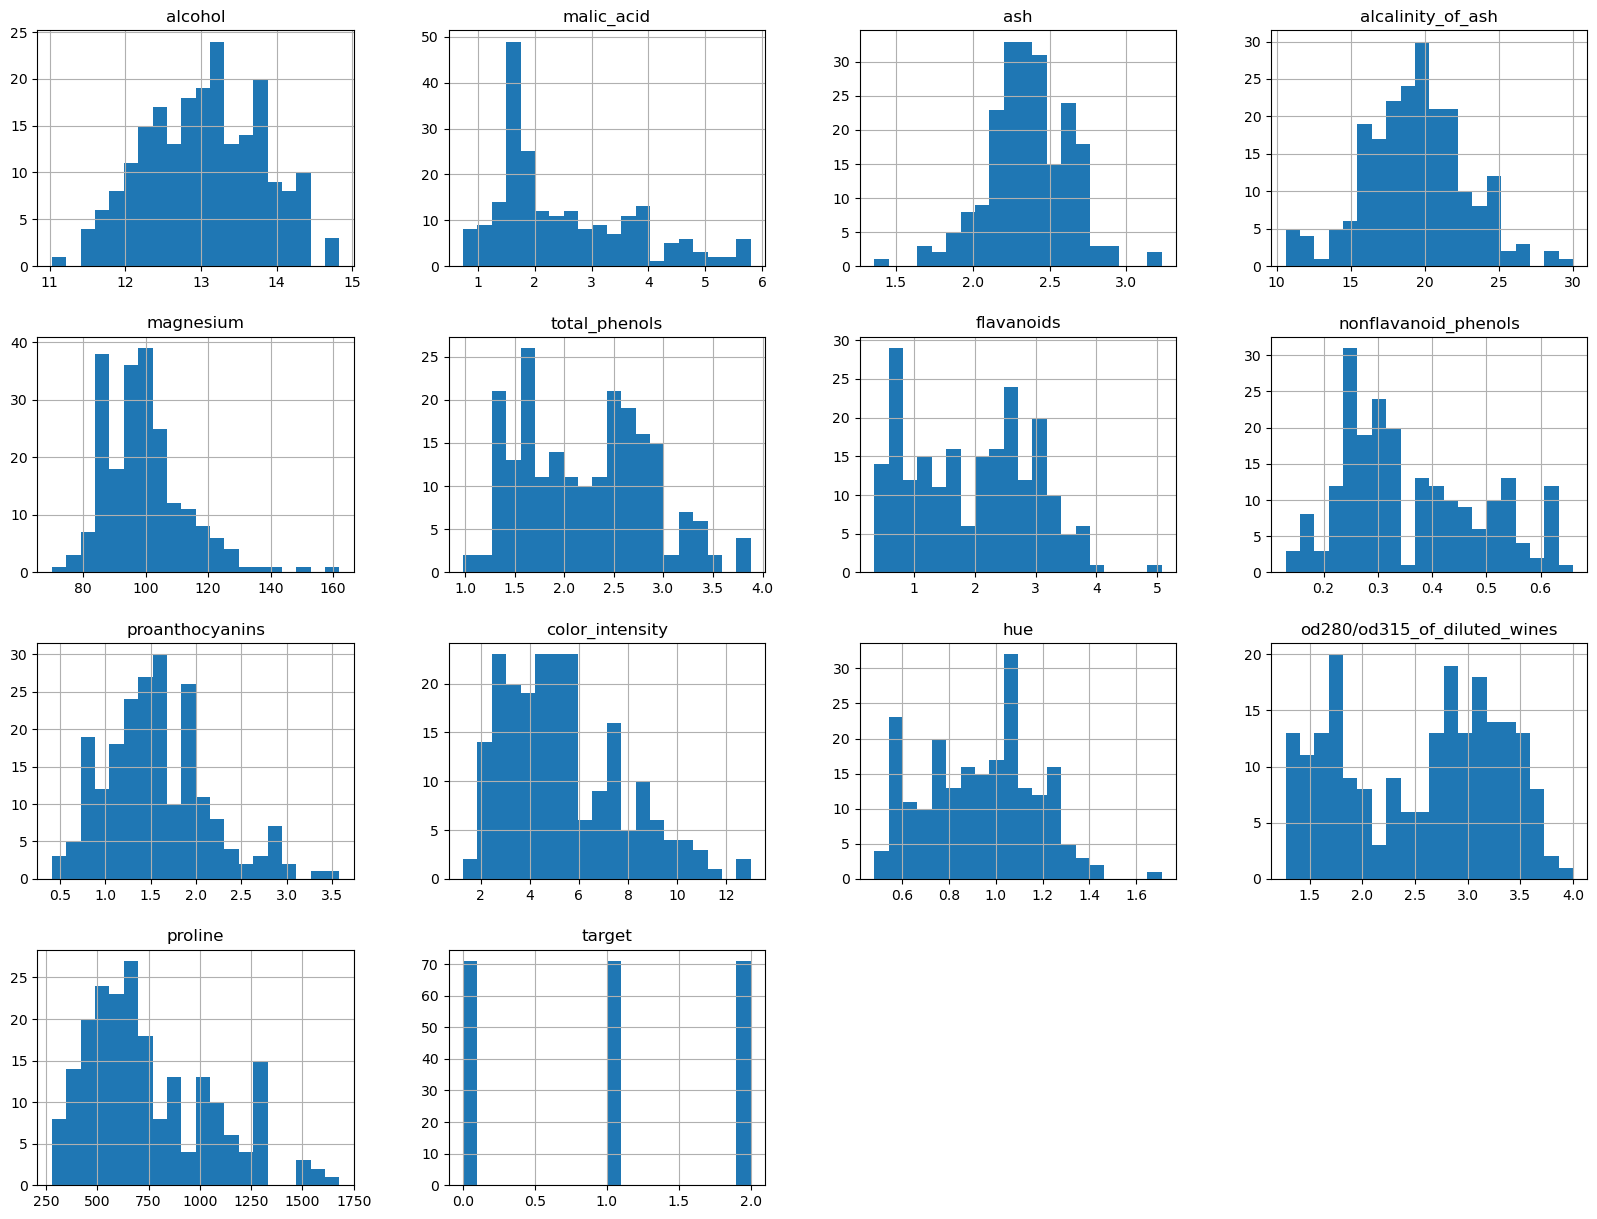

In [15]:
balanced_wine_data_df.hist(bins = 20, figsize = (20,15))
plt.show()

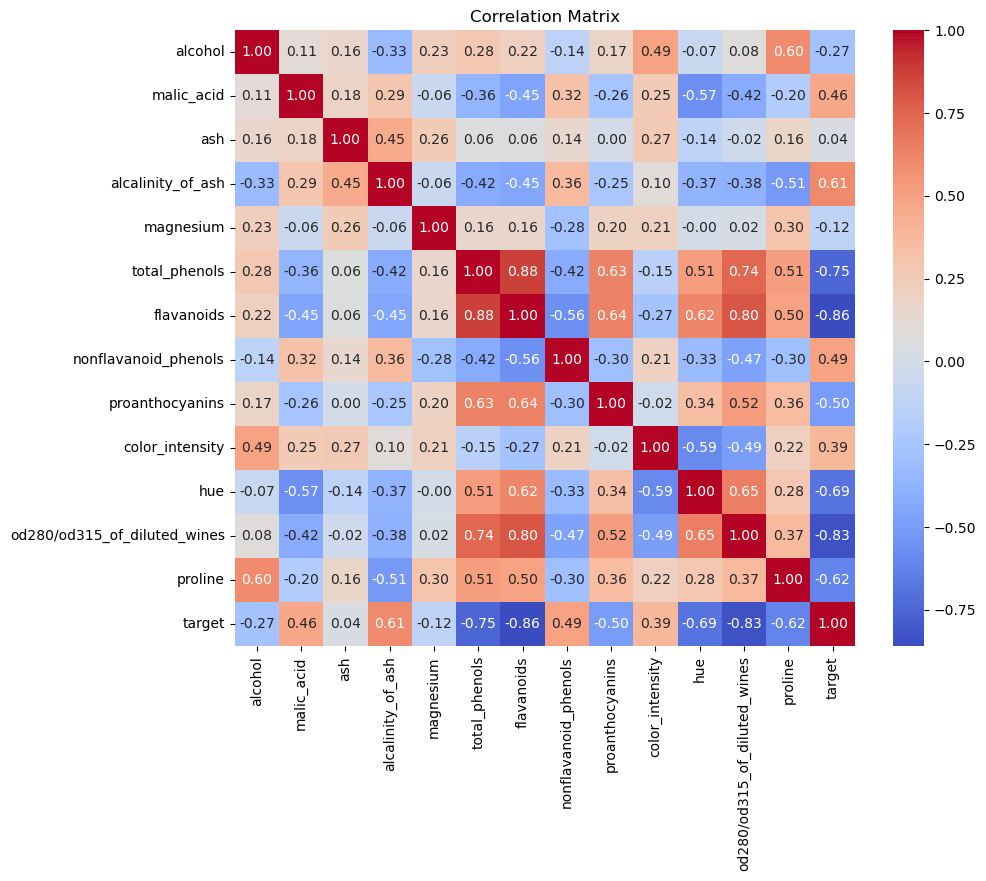

In [16]:
# # Correlation matrix

plt.figure(figsize=(10, 8))
sns.heatmap(balanced_wine_data_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [17]:
'''1. Correlation matrix take aways:
- The correlation matrix shows that some features are highly correlated with each other, 
    such as 'total_phenols' with 'flavanoids' ,'total_phenols' with 'od280/od315_of_diluted_wines' and
    'od280/od315_of_diluted_wines' with 'total_phenols' which suggests that these features may provide similar information.
- The target variable (wine class) has a moderate correlation with several features, indicating that these features 
    can help distinguish between different wine classes.
- Features like 'alcalinity_of_ash' , 'total_phenols' , 'flavanoids', 'hue', 'od280/od315_of_diluted_wines' and 'proline' 
    show strong correlations with the target variable, suggesting they are important for classification.'''

"1. Correlation matrix take aways:\n- The correlation matrix shows that some features are highly correlated with each other, \n    such as 'total_phenols' with 'flavanoids' ,'total_phenols' with 'od280/od315_of_diluted_wines' and\n    'od280/od315_of_diluted_wines' with 'total_phenols' which suggests that these features may provide similar information.\n- The target variable (wine class) has a moderate correlation with several features, indicating that these features \n    can help distinguish between different wine classes.\n- Features like 'alcalinity_of_ash' , 'total_phenols' , 'flavanoids', 'hue', 'od280/od315_of_diluted_wines' and 'proline' \n    show strong correlations with the target variable, suggesting they are important for classification."

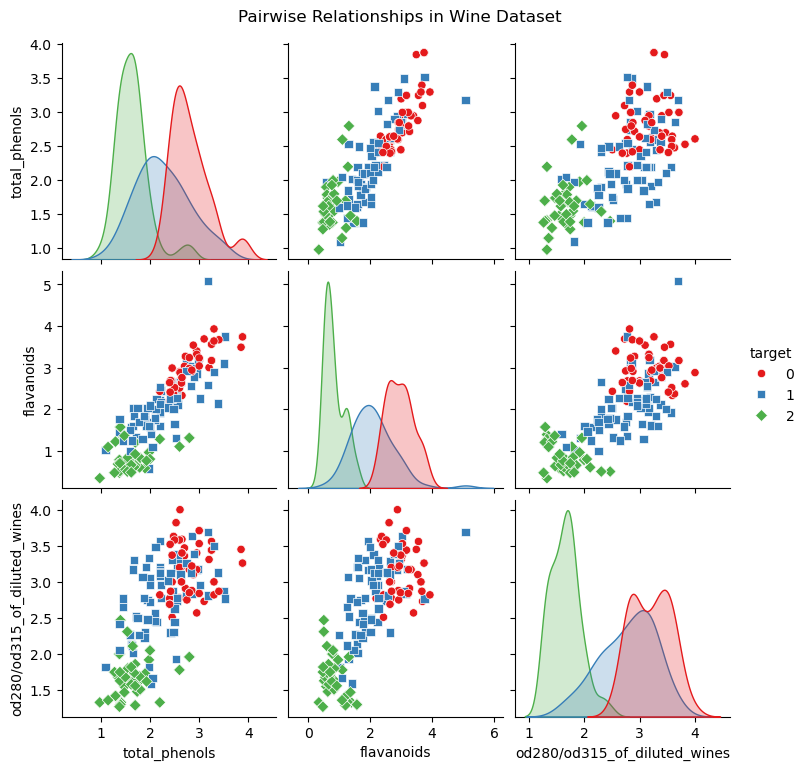

In [18]:
# plotting pairwise relationships
sns.pairplot(balanced_wine_data_df[['total_phenols', 'flavanoids', 'od280/od315_of_diluted_wines', 'target']], hue='target', palette='Set1', markers=["o", "s", "D"])
plt.suptitle('Pairwise Relationships in Wine Dataset', y=1.02)
plt.show()

# 5. PCA

In [19]:
# pca for correlated features
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_features = pca.fit_transform(balanced_wine_data_df[['total_phenols', 'flavanoids', 'od280/od315_of_diluted_wines']])
balanced_wine_data_df['pca_features'] = pca_features
# Drop the original correlated features
balanced_wine_data_df.drop(columns=['total_phenols', 'flavanoids', 'od280/od315_of_diluted_wines'], inplace=True)
# Check the updated DataFrame
print(balanced_wine_data_df.head())

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  \
0    13.34        0.94  2.36               17.0      110.0   
1    13.17        2.59  2.37               20.0      120.0   
2    12.07        2.16  2.17               21.0       85.0   
3    13.08        3.90  2.36               21.5      113.0   
4    14.22        1.70  2.30               16.3      118.0   

   nonflavanoid_phenols  proanthocyanins  color_intensity   hue  proline  \
0                  0.55             0.42             3.17  1.02    750.0   
1                  0.53             1.46             9.30  0.60    840.0   
2                  0.37             1.35             2.76  0.86    378.0   
3                  0.34             1.14             9.40  0.57    550.0   
4                  0.26             2.03             6.38  0.94    970.0   

   target  pca_features  
0       1     -0.666591  
1       2     -1.672087  
2       1      1.046435  
3       2     -1.398700  
4       0      1.586524  


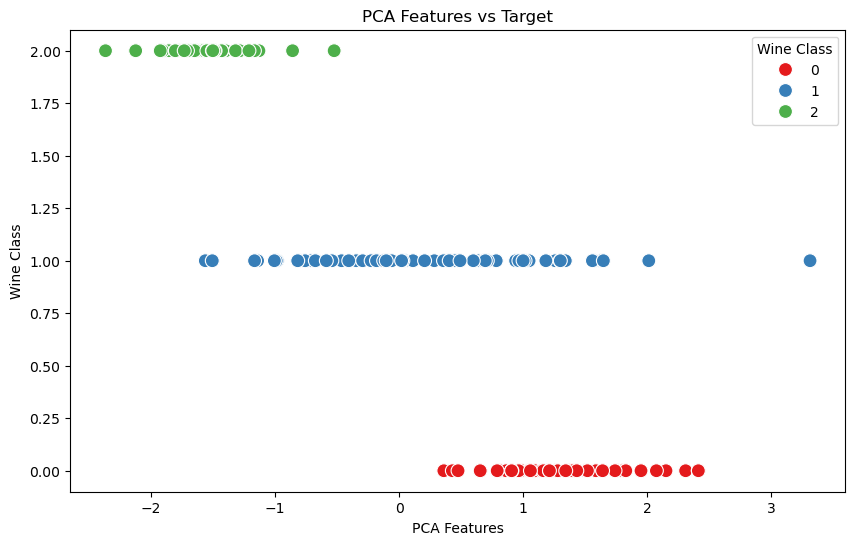

In [20]:
#plotting the PCA features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=balanced_wine_data_df, x='pca_features', y='target', hue='target', palette='Set1', s=100)
plt.title('PCA Features vs Target')
plt.xlabel('PCA Features')
plt.ylabel('Wine Class')
plt.legend(title='Wine Class')
plt.show()

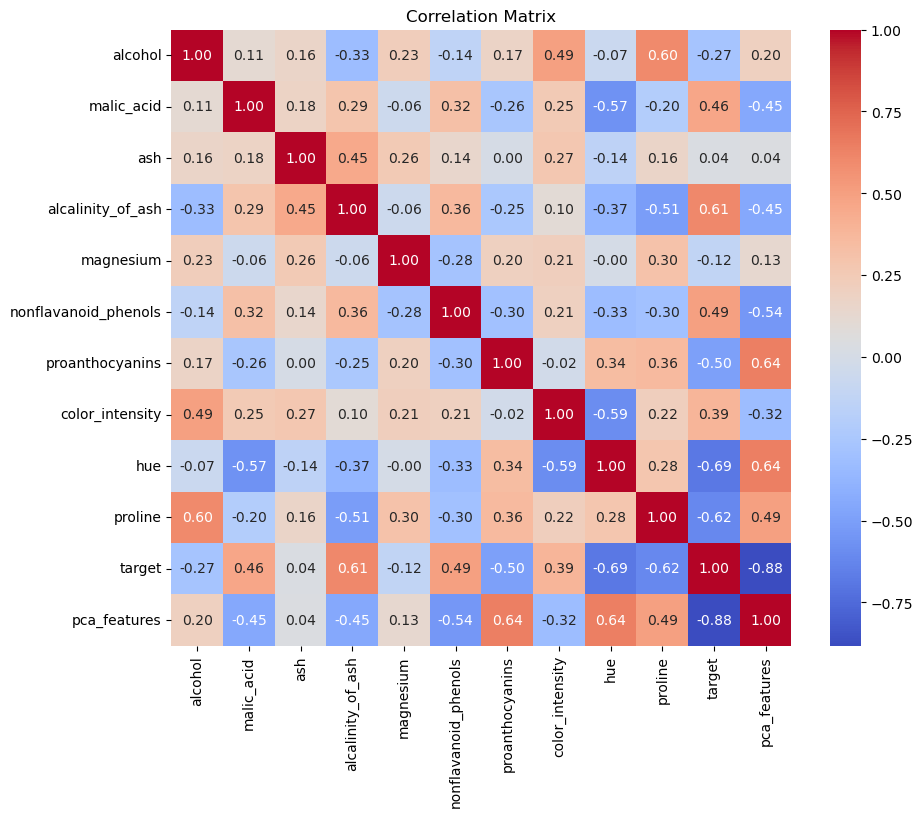

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(balanced_wine_data_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 6. Combining All preprocessing and Data loader into one function

In [22]:
def load_and_preprocess_data():
    wine_data = load_wine(as_frame=True)
    wine_data_df = wine_data.frame

    minority_class_1 = wine_data_df[wine_data_df['target'] == 0]
    majority_class = wine_data_df[wine_data_df['target'] == 1]
    minority_class_2 = wine_data_df[wine_data_df['target'] == 2]
    # Upsample minority classes
    minority_class_1_upsampled = resample(minority_class_1,
                                        replace=True,     # sample with replacement
                                        n_samples=len(majority_class),    # to match majority class
                                        random_state=RANDOM_SEED)  # reproducible results
    minority_class_2_upsampled = resample(minority_class_2,
                                        replace=True,     # sample with replacement
                                        n_samples=len(majority_class),    # to match majority class
                                        random_state=RANDOM_SEED)  # reproducible results
    # Combine majority class with upsampled minority classes
    balanced_wine_data_df = pd.concat([majority_class, minority_class_1_upsampled, minority_class_2_upsampled])
    # Shuffle the dataset
    balanced_wine_data_df = balanced_wine_data_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    # Check the new class distribution
    class_distribution_balanced = balanced_wine_data_df['target'].value_counts()
    print("Balanced class distribution:\n", class_distribution_balanced)

    pca = PCA(n_components=1)
    pca_features = pca.fit_transform(balanced_wine_data_df[['total_phenols', 'flavanoids', 'od280/od315_of_diluted_wines']])
    balanced_wine_data_df['pca_features'] = pca_features
    # Drop the original correlated features
    balanced_wine_data_df.drop(columns=['total_phenols', 'flavanoids', 'od280/od315_of_diluted_wines'], inplace=True)
    
    #normalize the features
    from sklearn.preprocessing import StandardScaler
    
    X_scaled = StandardScaler().fit_transform(balanced_wine_data_df.drop(columns=['target']))
    data_scaled_df = pd.DataFrame(X_scaled, columns=balanced_wine_data_df.drop('target', axis=1).columns)
    data_scaled_df['target'] = balanced_wine_data_df['target']
    
    # Split the data into features and target
    X = balanced_wine_data_df.drop(columns=['target']).values
    y = balanced_wine_data_df['target'].values

    # Convert to PyTorch Tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    #create a tensor dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    #define split sizes
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)  # for reproducibility
    )

    # Create DataLoaders (optional)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Print sizes
    print("Train size:", len(train_dataset))
    print("Validation size:", len(val_dataset))
    print("Test size:", len(test_dataset))

    input_dim = X_tensor.shape[1]
    return train_loader, val_loader, test_loader, input_dim

In [23]:
train_loader, val_loader, test_loader, input_dim = load_and_preprocess_data()

Balanced class distribution:
 target
1    71
2    71
0    71
Name: count, dtype: int64
Train size: 170
Validation size: 21
Test size: 22


In [24]:
input_dim

11

# 7. Model Definition

In [25]:
class MultiClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout=0.1, lr=0.001):
        super(MultiClassificationModel, self).__init__()
        layers = []
        current_dim = input_dim  # Number of features in the input
        
        # Build hidden layers based on hidden_layers string (e.g., "128-64-32")
        hidden_units = [int(u) for u in hidden_layers.split('-')]

        for units in hidden_units:
            layers.append(nn.Linear(current_dim, units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            current_dim = units  # Update current_dim for the next layer
        layers.append(nn.Linear(current_dim, 3))  # Output layer for 3 classes
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
    def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, writer, OUTPUT_DIM, trial = None):
        model.to(DEVICE)
        best_val_loss = float('inf')

        # Initialize metrics for training and validation
        train_accuracy_metric = MulticlassAccuracy(num_classes=OUTPUT_DIM).to(DEVICE) # 
        val_accuracy_metric = MulticlassAccuracy(num_classes=OUTPUT_DIM).to(DEVICE) # 
        val_precision_metric = MulticlassPrecision(num_classes=OUTPUT_DIM, average='macro').to(DEVICE) # 
        val_recall_metric = MulticlassRecall(num_classes=OUTPUT_DIM, average='macro').to(DEVICE) # 
        val_f1_metric = MulticlassF1Score(num_classes=OUTPUT_DIM, average='macro').to(DEVICE)

        # Lists to store metrics for CSV logging
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        val_precisions = []
        val_recalls = []
        val_f1_scores = []


        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for batch_idx, (data,target) in enumerate(train_loader):
                inputs, targets = data.to(DEVICE), target.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                train_accuracy_metric.update(preds, targets)

            epoch_train_loss = running_loss / len(train_loader.dataset)
            epoch_train_accuracy = train_accuracy_metric.compute().item()
            train_accuracy_metric.reset()  # Reset for next epoch


            #validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for data, target in val_loader:
                    inputs, targets = data.to(DEVICE), target.to(DEVICE)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_running_loss += loss.item() * inputs.size(0)

                    # Update validation metrics
                    preds = torch.argmax(outputs, dim=1)
                    val_accuracy_metric.update(preds, target) # 
                    val_precision_metric.update(preds, target) # 
                    val_recall_metric.update(preds, target) # 
                    val_f1_metric.update(preds, target) # 
            
            epoch_val_loss = val_running_loss / len(val_loader.dataset)
            epoch_val_accuracy = val_accuracy_metric.compute().item()
            epoch_val_precision = val_precision_metric.compute().item()
            epoch_val_recall = val_recall_metric.compute().item()
            epoch_val_f1 = val_f1_metric.compute().item()

            # Reset validation metrics for next epoch
            val_accuracy_metric.reset()
            val_precision_metric.reset()
            val_recall_metric.reset()
            val_f1_metric.reset()

            #storing metrics for csv
            train_losses.append(epoch_train_loss)
            val_losses.append(epoch_val_loss)
            train_accuracies.append(epoch_train_accuracy)
            val_accuracies.append(epoch_val_accuracy)
            val_precisions.append(epoch_val_precision)
            val_recalls.append(epoch_val_recall)
            val_f1_scores.append(epoch_val_f1)

            # Log scalars to TensorBoard
            writer.add_scalar('Loss/Train', epoch_train_loss, epoch) # 
            writer.add_scalar('Accuracy/Train', epoch_train_accuracy, epoch) # 
            writer.add_scalar('Loss/Validation', epoch_val_loss, epoch) # 
            writer.add_scalar('Accuracy/Validation', epoch_val_accuracy, epoch) # 
            writer.add_scalar('Precision/Validation', epoch_val_precision, epoch) # 
            writer.add_scalar('Recall/Validation', epoch_val_recall, epoch) # 
            writer.add_scalar('F1-Score/Validation', epoch_val_f1, epoch) #


            # csv_logger.writerow([
            #                     epoch,
            #                     epoch_train_loss,
            #                     epoch_train_accuracy,
            #                     epoch_val_loss,
            #                     epoch_val_accuracy,
            #                     epoch_val_precision,
            #                     epoch_val_recall,
            #                     epoch_val_f1]) # CSV logging

            if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
                print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, "
                f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}, "
                f"Val Prec: {epoch_val_precision:.4f}, Val Rec: {epoch_val_recall:.4f}, Val F1: {epoch_val_f1:.4f}")

            # Log the model graph (requires a sample input)
            dummy_input = torch.randn(1, input_dim).to(DEVICE)
            writer.add_graph(model, dummy_input) # [6, 7]

            writer.flush() # 
            writer.close() # 
            # print("\nTensorBoard logs generated in 'runs/wine_classification_initial_run'.")
            # print("To view, run: tensorboard --logdir=runs")
            # metrics_df = pd.DataFrame({
            #                             'Epoch': range(1, num_epochs + 1),
            #                             'Train Loss': train_losses,
            #                             'Train Accuracy': train_accuracies,
            #                             'Validation Loss': val_losses,
            #                             'Validation Accuracy': val_accuracies,
            #                             'Validation Precision': val_precisions,
            #                             'Validation Recall': val_recalls,
            #                             'Validation F1-Score': val_f1_scores
            #                 })
            # metrics_df.to_csv('training_metrics.csv', index=False)
            # Optuna pruning (if applicable)
            if trial:
                trial.report(epoch_val_loss, epoch)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
                
            # Early stopping (simple example for demonstration)
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss

        return epoch_val_loss
    
    # Hyperparameter tuning with Optuna
    def objective(trial):
        """Optuna objective function for hyperparameter optimization."""
        # Define hyperparameter search space [21]
        learning_rate = trial.suggest_float("lr", 0.0005, 0.001, log=True) # [2, 21]
        hidden_layers_str = trial.suggest_categorical("hidden_layers", ["44-22-11","256-128-64-32", "512-256-128", "512-256-128-64"]) # [2, 19]
        dropout_rate = trial.suggest_float("dropout", 0.0, 0.2) # [2, 16]
        epochs = 100#trial.suggest_int("epochs", 50, 500, step=50) # Limited for faster tuning example
        OUTPUT_DIM = 3  # Number of classes in the wine dataset
        # Re-load data for each trial to ensure fresh split (or use fixed split outside objective)
        train_loader, val_loader, _, input_dim = load_and_preprocess_data()
        # print(input_dim)
        model = MultiClassificationModel(input_dim, hidden_layers_str, dropout_rate).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate) # [5, 9]
        criterion = nn.CrossEntropyLoss() # [5, 9]

        # Metrics for this trial
        trial_val_accuracy_metric = MulticlassAccuracy(num_classes=OUTPUT_DIM).to(DEVICE)


        # Initialize TensorBoard writer and CSV logger for this trial
        writer = SummaryWriter(log_dir=os.path.join(LOG_DIR, f"optuna_trial_{trial.number}"))
        # csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')

        # csv_logger = csv.writer(csv_file)
        # Write CSV headers
        # csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"]) # CSV headers

        print(f"\nStarting Optuna Trial {trial.number} with params: {trial.params}")
        val_loss = MultiClassificationModel.train_model(model, train_loader, val_loader, criterion, optimizer, epochs, writer, OUTPUT_DIM, trial)
        final_val_accuracy = trial_val_accuracy_metric.compute().item()
        trial_val_accuracy_metric.reset()
        writer.close()
        # csv_file.close()
        return val_loss

# 8. Run the model for Hyperparameter tuning

In [26]:
train_loader, val_loader, test_loader, input_dim = load_and_preprocess_data()


Balanced class distribution:
 target
1    71
2    71
0    71
Name: count, dtype: int64
Train size: 170
Validation size: 21
Test size: 22


In [27]:
input_dim

11

## 8.1 Optuna Optimization

In [31]:
# --- Hyperparameter Tuning (Optuna) ---
print("--- Starting Hyperparameter Tuning with Optuna ---")
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler()) # Minimize validation loss [21]
study.optimize(MultiClassificationModel.objective, n_trials=NUM_TRIALS_OPTUNA) # Run for a limited number of trials or time
print("\n--- Optuna Tuning Results ---")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best validation loss: {study.best_value:.4f}")
print(f"Best hyperparameters: {study.best_params}")

--- Starting Hyperparameter Tuning with Optuna ---
Balanced class distribution:
 target
1    71
2    71
0    71
Name: count, dtype: int64
Train size: 170
Validation size: 21
Test size: 22

Starting Optuna Trial 0 with params: {'lr': 0.0007009120512778363, 'hidden_layers': '512-256-128', 'dropout': 0.11443845470834675}
Epoch 10/100 - Train Loss: 1.9722, Train Acc: 0.2941, Val Loss: 1.2785, Val Acc: 0.4286, Val Prec: 0.4667, Val Rec: 0.4167, Val F1: 0.3238
Epoch 20/100 - Train Loss: 1.0656, Train Acc: 0.4471, Val Loss: 0.7573, Val Acc: 0.6667, Val Prec: 0.4537, Val Rec: 0.5509, Val F1: 0.4967
Epoch 30/100 - Train Loss: 0.9140, Train Acc: 0.5353, Val Loss: 0.5760, Val Acc: 0.8095, Val Prec: 0.8974, Val Rec: 0.7083, Val F1: 0.7172
Epoch 40/100 - Train Loss: 0.9094, Train Acc: 0.5353, Val Loss: 0.5944, Val Acc: 0.7143, Val Prec: 0.6964, Val Rec: 0.7269, Val F1: 0.7000
Epoch 50/100 - Train Loss: 0.7596, Train Acc: 0.6471, Val Loss: 0.6376, Val Acc: 0.6190, Val Prec: 0.6343, Val Rec: 0.6528, 

In [ ]:
Best hyperparameters: {'lr': 0.000907927757740544, 'hidden_layers': '512-256-128', 'dropout': 0.08978820928014533}
Best hyperparameters: {'lr': 0.0009195152731450349, 'hidden_layers': '256-128-64-32', 'dropout': 0.008448557133486868}
Best hyperparameters: {'lr': 0.0007951420031227641, 'hidden_layers': '512-256-128-64', 'dropout': 0.0070801125155722285}

## 8.2 Checking induvidual Best Hyper parameters for cross verification

In [ ]:
def best_hidden_layers(train_loader, val_loader, input_dim):
    """searches for the best hidden layers from the best params"""
    best_val_loss = float('inf')
    best_layers = None
    best_params = None
    OUTPUT_DIM = 3  # Number of classes in the wine dataset
    fixed_lr = 0.000
    fixed_dropout = 0.008
    for layers in ["128-64-32", "64-32-16","256-128-64", "256-128-64-32", "512-256-128", "512-256-128-64"]:
        print(f"Training with lr={fixed_lr}, hidden_layers={layers}, dropout={fixed_dropout}")
        model = MultiClassificationModel(input_dim, layers, fixed_dropout).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=fixed_lr)
        criterion = nn.CrossEntropyLoss()

        writer = SummaryWriter(log_dir=tempfile.mkdtemp())
        # csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')
        # csv_logger = csv.writer(csv_file)
        # csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"])  

        trial_val_accuracy = MultiClassificationModel.train_model(model, train_loader, val_loader, criterion, optimizer, 100, writer, OUTPUT_DIM)

        writer.close()
        # csv_file.close()

        # Check if this is the best model so far
        if trial_val_accuracy < best_val_loss:
            best_val_loss = trial_val_accuracy
            best_params = (layers)

    print(f"Best validation loss: {best_val_loss:.4f} with parameters: {best_params}")
    return best_params
      
best_layers = best_hidden_layers(train_loader, val_loader, input_dim)

Training with lr=0.0007, hidden_layers=128-64-32, dropout=0.008
Epoch 10/100 - Train Loss: 1.1181, Train Acc: 0.5294, Val Loss: 0.7600, Val Acc: 0.6190, Val Prec: 0.7611, Val Rec: 0.6111, Val F1: 0.6080
Epoch 20/100 - Train Loss: 0.9575, Train Acc: 0.5882, Val Loss: 0.5670, Val Acc: 0.8571, Val Prec: 0.8500, Val Rec: 0.8380, Val F1: 0.8418
Epoch 30/100 - Train Loss: 0.9089, Train Acc: 0.5588, Val Loss: 0.6152, Val Acc: 0.7619, Val Prec: 0.8259, Val Rec: 0.7176, Val F1: 0.7423
Epoch 40/100 - Train Loss: 0.7614, Train Acc: 0.6294, Val Loss: 0.5537, Val Acc: 0.8571, Val Prec: 0.8500, Val Rec: 0.8380, Val F1: 0.8418
Epoch 50/100 - Train Loss: 0.7143, Train Acc: 0.6412, Val Loss: 0.5030, Val Acc: 0.8571, Val Prec: 0.8500, Val Rec: 0.8380, Val F1: 0.8418
Epoch 60/100 - Train Loss: 0.7009, Train Acc: 0.6588, Val Loss: 0.4839, Val Acc: 0.8571, Val Prec: 0.9167, Val Rec: 0.7917, Val F1: 0.8190
Epoch 70/100 - Train Loss: 0.6796, Train Acc: 0.6765, Val Loss: 0.4733, Val Acc: 0.8571, Val Prec: 0.9

In [38]:
def best_learning_rate_layers(train_loader, val_loader, input_dim):
    """searches for the best hidden layers from the best params"""
    best_val_loss = float('inf')
    best_lr = None
    best_params = None
    OUTPUT_DIM = 3  # Number of classes in the wine dataset
    fixed_layer = "512-256-128"
    fixed_dropout = 0.008
    for lr in [0.0005, 0.0007, 0.0009, 0.001]:
        print(f"Training with lr={lr}, hidden_layers={fixed_layer}, dropout={fixed_dropout}")
        model = MultiClassificationModel(input_dim, fixed_layer, fixed_dropout).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        writer = SummaryWriter(log_dir=tempfile.mkdtemp())
        # csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')
        # csv_logger = csv.writer(csv_file)
        # csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"])  

        trial_val_accuracy = MultiClassificationModel.train_model(model, train_loader, val_loader, criterion, optimizer, 100, writer, OUTPUT_DIM)

        writer.close()
        # csv_file.close()

        # Check if this is the best model so far
        if trial_val_accuracy < best_val_loss:
            best_val_loss = trial_val_accuracy
            best_params = (lr)

    print(f"Best validation loss: {best_val_loss:.4f} with parameters: {best_params}")
    return best_params
      
best_lr = best_learning_rate_layers(train_loader, val_loader, input_dim)

Training with lr=0.0005, hidden_layers=512-256-128, dropout=0.008
Epoch 10/100 - Train Loss: 1.0951, Train Acc: 0.5176, Val Loss: 1.0573, Val Acc: 0.4762, Val Prec: 0.3045, Val Rec: 0.5417, Val F1: 0.3889
Epoch 20/100 - Train Loss: 0.8864, Train Acc: 0.5941, Val Loss: 0.5340, Val Acc: 0.8571, Val Prec: 0.9167, Val Rec: 0.7917, Val F1: 0.8190
Epoch 30/100 - Train Loss: 0.7861, Train Acc: 0.5882, Val Loss: 0.5024, Val Acc: 0.8571, Val Prec: 0.9167, Val Rec: 0.7917, Val F1: 0.8190
Epoch 40/100 - Train Loss: 0.6742, Train Acc: 0.6588, Val Loss: 0.5033, Val Acc: 0.8571, Val Prec: 0.9167, Val Rec: 0.7917, Val F1: 0.8190
Epoch 50/100 - Train Loss: 0.6624, Train Acc: 0.6471, Val Loss: 0.4742, Val Acc: 0.8571, Val Prec: 0.9167, Val Rec: 0.7917, Val F1: 0.8190
Epoch 60/100 - Train Loss: 0.7327, Train Acc: 0.6588, Val Loss: 0.4947, Val Acc: 0.8571, Val Prec: 0.8500, Val Rec: 0.8380, Val F1: 0.8418
Epoch 70/100 - Train Loss: 0.6261, Train Acc: 0.6941, Val Loss: 0.4820, Val Acc: 0.8571, Val Prec: 0

In [40]:
def best_dropout_rate_layers(train_loader, val_loader, input_dim):
    """searches for the best hidden layers from the best params"""
    best_val_loss = float('inf')
    best_lr = None
    best_params = None
    OUTPUT_DIM = 3  # Number of classes in the wine dataset
    fixed_layer = "512-256-128"
    fixed_lr = 0.0007
    for dropouts in [0.007, 0.009, 0.01, 0.02]:
        print(f"Training with lr={fixed_lr}, hidden_layers={fixed_layer}, dropout={dropouts}")
        model = MultiClassificationModel(input_dim, fixed_layer, dropouts).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=fixed_lr)
        criterion = nn.CrossEntropyLoss()

        writer = SummaryWriter(log_dir=tempfile.mkdtemp())
        # csv_file = open(os.path.join(writer.log_dir, "metrics.csv"), 'w', newline='')
        # csv_logger = csv.writer(csv_file)
        # csv_logger.writerow(["Epoch", "Train Loss", "Validation Loss"])  

        trial_val_accuracy = MultiClassificationModel.train_model(model, train_loader, val_loader, criterion, optimizer, 100, writer, OUTPUT_DIM)

        writer.close()
        # csv_file.close()

        # Check if this is the best model so far
        if trial_val_accuracy < best_val_loss:
            best_val_loss = trial_val_accuracy
            best_params = (dropouts)

    print(f"Best validation loss: {best_val_loss:.4f} with parameters: {best_params}")
    return best_params
      
best_dropouts = best_dropout_rate_layers(train_loader, val_loader, input_dim)

Training with lr=0.0007, hidden_layers=512-256-128, dropout=0.007
Epoch 10/100 - Train Loss: 0.9879, Train Acc: 0.5824, Val Loss: 0.8372, Val Acc: 0.5238, Val Prec: 0.3444, Val Rec: 0.5833, Val F1: 0.4319
Epoch 20/100 - Train Loss: 0.8005, Train Acc: 0.5882, Val Loss: 0.5469, Val Acc: 0.8095, Val Prec: 0.8674, Val Rec: 0.7546, Val F1: 0.7806
Epoch 30/100 - Train Loss: 0.7406, Train Acc: 0.6118, Val Loss: 0.6103, Val Acc: 0.5714, Val Prec: 0.7361, Val Rec: 0.6620, Val F1: 0.5250
Epoch 40/100 - Train Loss: 0.6908, Train Acc: 0.6941, Val Loss: 0.4723, Val Acc: 0.8571, Val Prec: 0.9167, Val Rec: 0.7917, Val F1: 0.8190
Epoch 50/100 - Train Loss: 0.7288, Train Acc: 0.6706, Val Loss: 0.5733, Val Acc: 0.7619, Val Prec: 0.7917, Val Rec: 0.8102, Val F1: 0.7520
Epoch 60/100 - Train Loss: 0.6376, Train Acc: 0.7000, Val Loss: 0.4570, Val Acc: 0.9048, Val Prec: 0.9394, Val Rec: 0.8750, Val F1: 0.8968
Epoch 70/100 - Train Loss: 0.6121, Train Acc: 0.7647, Val Loss: 0.4481, Val Acc: 0.9524, Val Prec: 0

# 9. Final Model Training with Best Parameters

In [41]:
print(study.best_params)

{'lr': 0.0007951420031227641, 'hidden_layers': '512-256-128-64', 'dropout': 0.0070801125155722285}


In [46]:
best_params = study.best_params
final_model = MultiClassificationModel(
        input_dim=input_dim,
        hidden_layers=best_params["hidden_layers"],
        dropout=best_params["dropout"]
    ).to(DEVICE)

final_optimizer = optim.Adam(final_model.parameters(), lr=best_params["lr"])
final_criterion = nn.CrossEntropyLoss()
final_epochs = 100

In [47]:
final_writer = SummaryWriter(log_dir=os.path.join(LOG_DIR, "final_model"))

In [48]:
MultiClassificationModel.train_model(final_model, 
                                     train_loader, 
                                     val_loader, 
                                     final_criterion, 
                                     final_optimizer, 
                                     final_epochs, 
                                     final_writer, 
                                     3)

Epoch 10/100 - Train Loss: 0.8612, Train Acc: 0.5471, Val Loss: 0.7488, Val Acc: 0.6190, Val Prec: 0.7778, Val Rec: 0.6991, Val F1: 0.5990
Epoch 20/100 - Train Loss: 0.7427, Train Acc: 0.6588, Val Loss: 0.5268, Val Acc: 0.8095, Val Prec: 0.7980, Val Rec: 0.7546, Val F1: 0.7683
Epoch 30/100 - Train Loss: 0.7477, Train Acc: 0.5824, Val Loss: 0.5725, Val Acc: 0.7619, Val Prec: 0.8259, Val Rec: 0.7176, Val F1: 0.7423
Epoch 40/100 - Train Loss: 0.6861, Train Acc: 0.6588, Val Loss: 0.5458, Val Acc: 0.8095, Val Prec: 0.8674, Val Rec: 0.7546, Val F1: 0.7806
Epoch 50/100 - Train Loss: 0.6441, Train Acc: 0.6706, Val Loss: 0.5010, Val Acc: 0.8571, Val Prec: 0.8500, Val Rec: 0.8380, Val F1: 0.8418
Epoch 60/100 - Train Loss: 0.6214, Train Acc: 0.6824, Val Loss: 0.4358, Val Acc: 0.8571, Val Prec: 0.9167, Val Rec: 0.7917, Val F1: 0.8190
Epoch 70/100 - Train Loss: 0.6700, Train Acc: 0.6529, Val Loss: 0.4441, Val Acc: 0.8095, Val Prec: 0.8974, Val Rec: 0.7083, Val F1: 0.7172
Epoch 80/100 - Train Loss: 

0.3145202398300171

In [49]:
final_writer.close()

In [50]:
# Evaluate the final model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    test_accuracy_metric = MulticlassAccuracy(num_classes=3).to(DEVICE)
    test_precision_metric = MulticlassPrecision(num_classes=3, average='macro').to(DEVICE)
    test_recall_metric = MulticlassRecall(num_classes=3, average='macro').to(DEVICE)
    test_f1_metric = MulticlassF1Score(num_classes=3, average='macro').to(DEVICE)
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            inputs, targets = data.to(DEVICE), target.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            test_accuracy_metric.update(preds, targets)
            test_precision_metric.update(preds, targets)
            test_recall_metric.update(preds, targets)
            test_f1_metric.update(preds, targets)
    test_loss /= len(test_loader.dataset)
    test_accuracy = test_accuracy_metric.compute().item()
    test_precision = test_precision_metric.compute().item()
    test_recall = test_recall_metric.compute().item()
    test_f1 = test_f1_metric.compute().item()
    test_accuracy_metric.reset()
    test_precision_metric.reset()
    test_recall_metric.reset()
    test_f1_metric.reset()
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
          f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1-Score: {test_f1:.4f}")
    return test_loss, test_accuracy, test_precision, test_recall, test_f1

test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(final_model, test_loader)

Test Loss: 0.5139, Test Accuracy: 0.7727, Test Precision: 0.7619, Test Recall: 0.8139, Test F1-Score: 0.7612
